# Load library

In [1]:
### visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mat

In [2]:
# data analysis and wrangling
import numpy as np
import pandas as pd
import re
from functools import partial

In [3]:
### Machine learning
## preprocess
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## algorithm
from sklearn.cluster import KMeans

In [4]:
# other library
import datetime
import calendar

In [5]:
# ignore sys warning
import warnings
import os
import glob
warnings.filterwarnings('ignore')

# Load data & manipulation

## load data from csvs

In [6]:
path =r'YOUR PATH' 
allFiles = glob.glob(path + "/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df_temp = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df_temp)
df = pd.concat(list_)

## get each usr first buy date

In [7]:
df['order_time'] = pd.to_datetime(df['order_time'].str[:10], format='%Y-%m-%d')
print(df.shape)
df = df.loc[df.order_status != 'Cancel']
print(df.shape)
df = df.loc[df.order_time >= '2016-03-01']
print(df.shape)

(1720784, 37)
(1634779, 37)
(1630841, 37)


## Seperate data by shop

In [8]:
print(df.shape)
df_1993 = df.loc[df.shop_id == 1993].reset_index().drop('index', axis=1)
print(df_1993.shape)
del df

(1630841, 37)
(1582089, 37)


## cart detail to cart brief

In [9]:
print(df_1993.shape)
df_1993_tg = df_1993[['cart_code', 'member_code', 'order_time', 'order_label', 'payment']]
print(df_1993_tg.shape)

(1582089, 37)
(1582089, 5)


In [10]:
df_1993_tg = df_1993_tg.groupby(['cart_code', 'member_code', 'order_time', 'order_label'], as_index=False).sum()
print(df_1993_tg.shape)

(480964, 5)


# RFM Method

## calculate Recency, Frequency, Monetary

In [11]:
now = pd.to_datetime('2017-12-01', format='%Y-%m-%d')

In [12]:
rfm = df_1993_tg.groupby('member_code', as_index=False).agg({'order_time': lambda x: (now - x.max()).days,     # Recency
                                                             'cart_code': lambda x: len(x),                    # Frequency
                                                             'payment': lambda x: x.sum()})                    # Monetary Value
rfm.columns = ['member_id', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,member_id,Recency,Frequency,Monetary
0,1,188,14,16031
1,2,42,18,16000
2,3,416,6,2537
3,4,116,3,2717
4,6,170,2,2260


In [13]:
# use quantile as threshold
thr = rfm.drop('member_id', axis=1).quantile(q=[0.25, 0.75])
thr = thr.to_dict()
thr

{'Frequency': {0.25: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 547.0, 0.75: 1409.0},
 'Recency': {0.25: 171.0, 0.75: 446.0}}

In [14]:
# cluster member by rfm
def rank_r(x, p, t):
    if x <= t[p][0.25]:
        return str(1)
    elif x <= t[p][0.75]: 
        return str(2)
    else:
        return str(3)
    
def rank_f(x, p, t):
    if x <= t[p][0.25]:
        return str(3)
    else:
        return str(1)
    
def rank_m(x, p, t):
    if x <= t[p][0.25]:
        return str(3)
    elif x <= t[p][0.75]: 
        return str(2)
    else:
        return str(1)

In [15]:
rfm['rank_r'] = rfm['Recency'].apply(rank_r, args=('Recency', thr))
rfm['rank_f'] = rfm['Frequency'].apply(rank_f, args=('Frequency', thr))
rfm['rank_m'] = rfm['Monetary'].apply(rank_m, args=('Monetary', thr))
rfm['cluster'] = rfm['rank_r'] + rfm['rank_f'] + rfm['rank_m']
rfm.head()

,member_id,Recency,Frequency,Monetary,rank_r,rank_f,rank_m,cluster
0,1,188,14,16031,2,1,1,211
1,2,42,18,16000,1,1,1,111
2,3,416,6,2537,2,1,1,211
3,4,116,3,2717,1,1,1,111
4,6,170,2,2260,1,1,1,111


## cluster defination

|Segment|RFM|Background Description|Marketing strategy|
|---|---|---|---|
|Best Customer|111|Bought most recently<br>most often<br>spend the most|No price incentives<br>new products<br>loyalty programs<br>Free marketing tools|
|New Customer|1xx|Buy one time & haven't lost|Aggressive marketing|
|Loyal Customer|x1x|Buy most frequently|Bulid long term relationship|
|Big Spenders|xx1|Spend the most|Market your most expensive products|
|Almost Lost|211|Haven’t purchased for some time, but purchased frequently and spend the most|Aggressive price incentives|
|Lost Customers|311|Haven’t purchased for some time, but purchased frequently and spend the most|Aggressive price incentives|
|Cheap Lost|333|Last purchased long ago, purchased few, and spent little|Never mind!|

In [16]:
def segment(rows):
    if rows['cluster'] == '111':
        return 'Best Customer'
    elif rows['cluster'] == '211':
        return 'Almost Lost'
    elif rows['cluster'] == '311':
        return 'Lost Customer'
    elif rows['rank_r'] == '3':
        return 'Cheap Lost'
    elif rows['rank_f'] == '1':
        return 'Loyal Customer'
    elif rows['rank_m'] == '1':
        return 'Big Spenders'
    elif rows['rank_f'] == '3':
        return 'New Customer'
    else:
        return rows['cluster']

In [17]:
rfm['segment'] = rfm.apply(segment, axis=1)
rfm.head()

,member_id,Recency,Frequency,Monetary,rank_r,rank_f,rank_m,cluster,segment
0,1,188,14,16031,2,1,1,211,Almost Lost
1,2,42,18,16000,1,1,1,111,Best Customer
2,3,416,6,2537,2,1,1,211,Almost Lost
3,4,116,3,2717,1,1,1,111,Best Customer
4,6,170,2,2260,1,1,1,111,Best Customer


# Brief of Segmentation

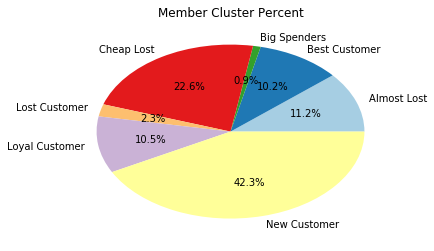

In [18]:
rfm_cnt = rfm.groupby('segment', as_index=False).count()[['segment', 'member_id']]
plt.pie(data=rfm_cnt, x='member_id', labels='segment', autopct='%1.1f%%', colors=mat.cm.Paired(np.arange(7)/7.))
plt.title('Member Cluster Percent')
plt.show()

Text(0.5,1,'Each Segmentation Recency')

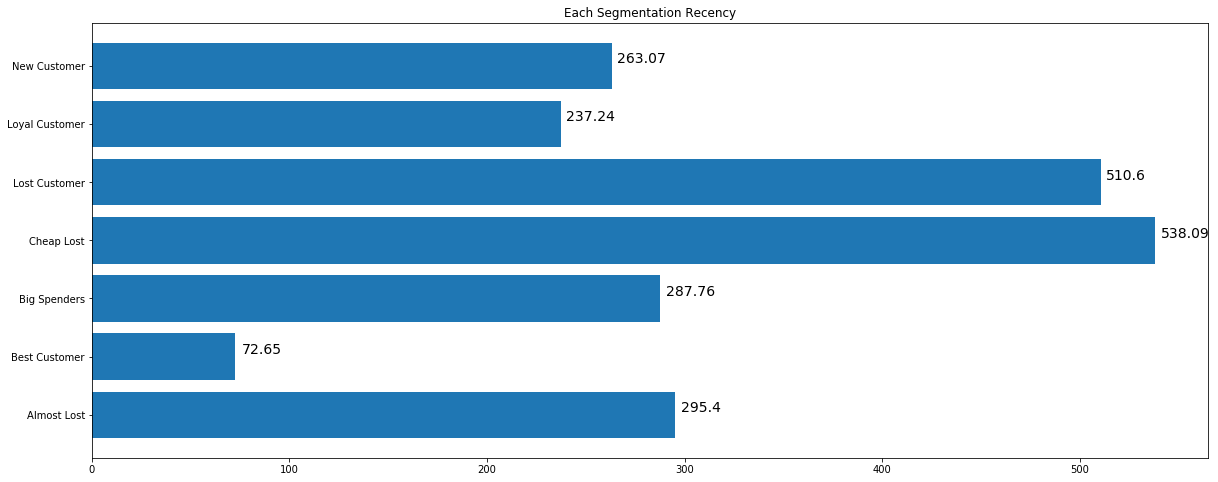

In [19]:
rfm_bf = rfm.groupby('segment', as_index=False).mean()[['segment', 'Recency', 'Frequency', 'Monetary']]
fig, ax = plt.subplots(figsize=(20,8))
ax.barh(rfm_bf['segment'], rfm_bf['Recency'], align='center', )
for i, v in enumerate(rfm_bf['Recency']):
    ax.text(v + 3, i + .05, str(np.round(v, 2)), color='black', size=14)
plt.title('Each Segmentation Recency')

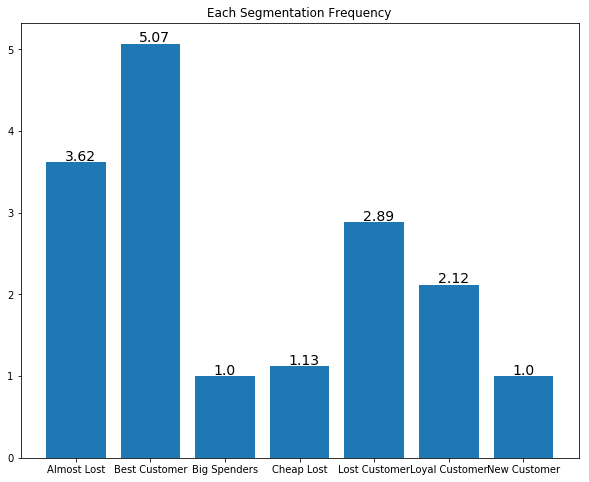

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(rfm_bf['segment'], rfm_bf['Frequency'], align='center', )
for i, v in enumerate(rfm_bf['Frequency']):
    ax.text(i-0.15, v+0.02, str(np.round(v, 2)), color='black', size=14)
plt.title('Each Segmentation Frequency')
plt.show()

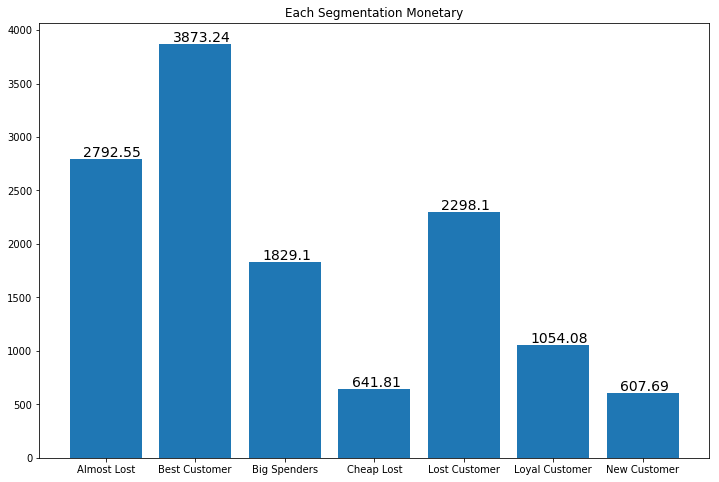

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(rfm_bf['segment'], rfm_bf['Monetary'], align='center', )
for i, v in enumerate(rfm_bf['Monetary']):
    ax.text(i-0.25, v+20, str(np.round(v, 2)), color='black', size=14)
plt.title('Each Segmentation Monetary')
plt.show()